In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import ast, os, gc, pdb, random, time

from fastai.callback.all import *
from fastai.data.block import CategoryBlock, ColReader, ColSplitter, DataBlock, IndexSplitter, RegressionBlock
from fastai.imports import *
from fastai.layers import SigmoidRange
from fastai.learner import *
from fastai.losses import CrossEntropyLossFlat, MSELossFlat, LabelSmoothingCrossEntropyFlat
from fastai.optimizer import Adam
from fastai.metrics import *
from fastai.torch_core import *
from fastai.torch_imports import *
from fastcore.transform import Transform
from sklearn.model_selection import train_test_split
from torch.utils.checkpoint import checkpoint
from transformers import (
    AutoConfig,
    AutoModelForNextSentencePrediction,
    AutoModelForSequenceClassification,
    DebertaV2Model,
    logging,
)
from transformers.models.deberta_v2.modeling_deberta_v2 import ContextPooler
from transformers.models.deberta_v2.modeling_deberta_v2 import StableDropout

from blurr.callbacks import GradientCheckpointing
from blurr.text.data.core import TextBlock, BatchTokenizeTransform
from blurr.text.modeling.core import BaseModelWrapper, BaseModelCallback, blurr_splitter
from blurr.text.utils import get_hf_objects
from blurr.utils import PreCalculatedCrossEntropyLoss, PreCalculatedMSELoss, set_seed

# silence all the HF warnings
warnings.simplefilter("ignore")
logging.set_verbosity_error()
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
gpu_num = 0

torch.cuda.set_device(gpu_num)
print(f"Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}")

Using GPU #0: GeForce GTX 1080 Ti


In [4]:
random_seed = 2022
val_pct = 0.25
bsz = 8
data_subset_pct = 1.0

# HF objects
model_checkpoint = "microsoft/deberta-v3-small"
model_cls = AutoModelForSequenceClassification

# model_checkpoint = "bert-base-uncased"
# model_cls = AutoModelForNextSentencePrediction

## Data

In [5]:
raw_train_df = pd.read_csv("../../data/clean/segmentation_train.csv", index_col=None)
raw_train_df["other_topic_seqs"] = raw_train_df["other_topic_seqs"].apply(ast.literal_eval)
raw_train_df.reset_index(inplace=True)

print(len(raw_train_df))
raw_train_df.head()

25383


,index,course_title,lesson_num,topic,seq,next_seq,is_topic_end,next_topic_begin_seq,other_topic_seqs
0,0,C-Squared Podcast,1,Intro,[Music] welcome everybody to episode one of a,chess themed podcast with myself christian kirilla and i'm fighting on caruana so what's up,False,NaN,"[christian well not so much fabi uh it's first of all great um to finally start a, podcast the chess podcast i know that um there's a lot of podcasts out there but, i wanted to bring our own tune to the mix and i think uh yeah i'm, excited about that so that's uh the first thing how about yourself fabian well i'm back in the states after it's, been a while at your home it's good to be here it's my first time in uh visiting here and uh, yeah it's been an interesting few months played a lot of chess which is pretty cool but, also a bit difficult at times my home uh here we are not going to m..."
1,1,C-Squared Podcast,1,Intro,chess themed podcast with myself christian kirilla and i'm fighting on caruana so what's up,christian well not so much fabi uh it's first of all great um to finally start a,False,NaN,"[[Music] welcome everybody to episode one of a, podcast the chess podcast i know that um there's a lot of podcasts out there but, i wanted to bring our own tune to the mix and i think uh yeah i'm, excited about that so that's uh the first thing how about yourself fabian well i'm back in the states after it's, been a while at your home it's good to be here it's my first time in uh visiting here and uh, yeah it's been an interesting few months played a lot of chess which is pretty cool but, also a bit difficult at times my home uh here we are not going to mention the location because, those ..."
2,2,C-Squared Podcast,1,Intro,christian well not so much fabi uh it's first of all great um to finally start a,podcast the chess podcast i know that um there's a lot of podcasts out there but,False,NaN,"[[Music] welcome everybody to episode one of a, chess themed podcast with myself christian kirilla and i'm fighting on caruana so what's up, i wanted to bring our own tune to the mix and i think uh yeah i'm, excited about that so that's uh the first thing how about yourself fabian well i'm back in the states after it's, been a while at your home it's good to be here it's my first time in uh visiting here and uh, yeah it's been an interesting few months played a lot of chess which is pretty cool but, also a bit difficult at times my home uh here we are not going to mention the location beca..."
3,3,C-Squared Podcast,1,Intro,podcast the chess podcast i know that um there's a lot of podcasts out there but,i wanted to bring our own tune to the mix and i think uh yeah i'm,False,NaN,"[[Music] welcome everybody to episode one of a, chess themed podcast with myself christian kirilla and i'm fighting on caruana so what's up, christian well not so much fabi uh it's first of all great um to finally start a, excited about that so that's uh the first thing how about yourself fabian well i'm back in the states after it's, been a while at your home it's good to be here it's my first time in uh visiting here and uh, yeah it's been an interesting few months played a lot of chess which is pretty cool but, also a bit difficult at times my home uh here we are not going to mention th..."
4,4,C-Squared Podcast,1,Intro,i wanted to bring our own tune to the mix and i think uh yeah i'm,excited about that so that's uh the first thing how about yourself fabian well i'm back in the states after it's,False,NaN,"[[Music] welcome everybody to episode one of a, chess themed podcast with myself christian kirilla and i'm fighting on caruana so what's up, christian well not so much fabi uh it's first of all great um to finally start a, podcast the chess podcast i know that um there's a lot of podcasts out there but, been a while at your home it's good to be here it's my first time in uh visiting here and uh, yeah it's been an interesting few months played a lot of chess which is pretty cool but, als

In [6]:
raw_train_df["seq"].sample(n=1).values[0].strip()

"so to start let's talk about how to address underfitting so how how do we reduce bias and here are some strategies that you"

### Train Eval split

For training we need to remove sequences for which there is not a "next_seq" (e.g., we are at end of a topic)

In [7]:
train_df = raw_train_df[raw_train_df["is_topic_end"] == False].copy()
print(len(train_df))

24786


Validation set should ideally ***not*** include courses in the training set

In [8]:
# if we were just concerned with creating a validation set and nothing else
_, val_idxs = train_test_split(range(len(train_df)), test_size=val_pct, random_state=random_seed)


# # shuffle dataset - optional subset for faster iteration
# train_df = train_df.sample(frac=data_subset_pct, random_state=random_seed).reset_index(drop=True)

# courses = train_df["course_title"].unique()

# np.random.seed(random_seed)
# np.random.shuffle(courses)

# val_sz = int(len(courses) * val_pct)
# val_courses = courses[:val_sz]

# is_val = np.isin(train_df["course_title"], val_courses)

# idxs = np.arange(len(train_df))
# val_idxs = idxs[is_val]
# trn_idxs = idxs[~is_val]

## HF objects

In [9]:
if random_seed:
    set_seed(random_seed)

    # need to create configuration object separately because we may be adding new attributes (e.g., cls_dropout)
    hf_config = AutoConfig.from_pretrained(model_checkpoint)
    hf_config.update({})

    hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(
        model_checkpoint,
        model_cls=model_cls,
        config=hf_config,
        tokenizer_kwargs={},
        model_kwargs={},
    )

## DataLoaders

In [10]:
class SiameseBatchTokenizeTransform(BatchTokenizeTransform):
    def __init__(self, use_next_pos_prob=0.75, use_adjacent_neg_prob=0.5, **kwargs):
        super().__init__(**kwargs)
        self.use_next_pos_prob = use_next_pos_prob
        self.use_adjacent_neg_prob = use_adjacent_neg_prob

    def encodes(self, samples, return_batch_encoding=False):
        # our positive example
        pos_ex_idx = 0 if random.uniform(0, 1) < self.use_next_pos_prob else 1
        updated_samples1, inputs1 = super().encodes(
            [(s[0][pos_ex_idx] if s[0][pos_ex_idx] != "xxNONExx" else s[0][0], *s[2:], *s[2:]) for s in samples],
            return_batch_encoding=True,
        )

        # our negative example (sometimes the adjacent will be ""; if that is the case use the other topic negative example which is at idx=1)
        neg_ex_idx = 0 if random.uniform(0, 1) < self.use_adjacent_neg_prob and pos_ex_idx == 0 else 1
        updated_samples2, inputs2 = super().encodes(
            [(s[1][neg_ex_idx] if s[1][neg_ex_idx] != "xxNONExx" else s[1][1], *s[2:]) for s in samples],
            return_batch_encoding=True,
        )

        # if there are no targets (e.g., when used for inference)
        if len(samples[0]) == 2:
            return [(inps1[0], inps2[0]) for inps1, inps2 in zip(updated_samples1, updated_samples2)]

        return [(inps1[0], inps2[0], inps1[-1]) for inps1, inps2 in zip(updated_samples1, updated_samples2)]

In [11]:
def build_pos_inputs(example, tok_sep_token="[SEP]", lower_case=True):
    seq_text = example["seq"].strip().lower() if lower_case else example["seq"].strip()
    next_seq_text = example["next_seq"].strip().lower() if lower_case else example["next_seq"].strip()

    non_adjacent_text = (
        random.choice(example["other_topic_seqs"]).strip() if len(example["other_topic_seqs"]) > 0 else None
    )
    if lower_case and non_adjacent_text:
        non_adjacent_text = non_adjacent_text.lower()

    if example["is_topic_end"] and example["next_topic_begin_seq"] and non_adjacent_text:
        # this is the last sequence in the topic so the only thing that will work here is to pair it with another non-adjacent seq in the same topic
        # and therefore we just duplicate it here.
        next_topic_begin_seq = (
            example["next_topic_begin_seq"].strip().lower() if lower_case else example["next_topic_begin_seq"].strip()
        )
        inp = (f"{seq_text}{tok_sep_token}{non_adjacent_text}", f"{seq_text}{tok_sep_token}{non_adjacent_text}")
    else:
        # the positive pair will be a seq + the next seq -or- the seq + a non-adjacent seq in the same topic
        inp = (
            f"{seq_text}{tok_sep_token}{next_seq_text}",
            f"{seq_text}{tok_sep_token}{non_adjacent_text}" if non_adjacent_text else "xxNONExx",
        )

    return inp

In [12]:
def build_neg_inputs(example, tok_sep_token="[SEP]", lower_case=True):
    seq_text = example["seq"].strip()

    # if at the last sequence for a topic, set the negative pair = seq + first sequence in next topic,
    # else get a sequence that is not adjacent but in same topic
    if example["is_topic_end"] and example["next_topic_begin_seq"]:
        neg_seq_non_adjacent_text = example["next_topic_begin_seq"].strip()
    elif len(example["other_topic_seqs"]) > 0:
        neg_seq_non_adjacent_text = random.choice(example["other_topic_seqs"]).strip()
    else:
        neg_seq_non_adjacent_text = "xxNONExx"

    # get a sequence that is in an entirely different topic
    # option 1: can be in same lesson but different topic or in a different course entirely
    # neg_seq_other_topic_text = (
    #     train_df["seq"][
    #         (train_df["course_title"] != example["course_title"]) | (train_df["lesson_num"] != example["lesson_num"])
    #     ]
    #     .sample(n=1)
    #     .values[0]
    #     .strip()
    # )

    # option 2: sample from a different course entirely
    neg_seq_other_topic_text = (
        train_df["seq"][(train_df["course_title"] != example["course_title"])].sample(n=1).values[0].strip()
    )

    if lower_case:
        seq_text = seq_text.lower()
        neg_seq_non_adjacent_text = neg_seq_non_adjacent_text.lower()
        neg_seq_other_topic_text = neg_seq_other_topic_text.lower()

    # our SiameseBatchTokenizeTransform will choose which one to use each time the item is fetched
    inp = (
        f"{seq_text}{tok_sep_token}{neg_seq_non_adjacent_text}",
        f"{seq_text}{tok_sep_token}{neg_seq_other_topic_text}",
    )

    return inp

In [13]:
def build_targets(example):
    return 0

In [14]:
def get_dls(df, hf_arch, hf_config, hf_tokenizer, hf_model, val_idxs, get_x=None):
    # define validation set
    splitter = IndexSplitter(val_idxs)

    if random_seed:
        set_seed(random_seed)

    batch_tokenize_tfm = SiameseBatchTokenizeTransform(
        use_adjacent_neg_prob=0.75,
        hf_arch=hf_arch,
        hf_config=hf_config,
        hf_tokenizer=hf_tokenizer,
        hf_model=hf_model,
        include_labels=False,
        max_length=True,
        truncation=True,
        tok_kwargs={},
    )

    blocks = (TextBlock(batch_tokenize_tfm=batch_tokenize_tfm), noop, CategoryBlock)

    get_pos_x = partial(build_pos_inputs, tok_sep_token=hf_tokenizer.sep_token, lower_case=True)
    get_neg_x = partial(build_neg_inputs, tok_sep_token=hf_tokenizer.sep_token, lower_case=True)
    get_y = partial(build_targets)

    dblock = DataBlock(
        blocks=blocks,
        get_x=[get_pos_x, get_neg_x],
        get_y=get_y,
        splitter=splitter,
        n_inp=2,
    )

    if random_seed:
        set_seed(random_seed)

    return dblock.dataloaders(df, bs=bsz, val_bs=bsz * 2)

In [15]:
dls = get_dls(train_df, hf_arch, hf_config, hf_tokenizer, hf_model, val_idxs=val_idxs)

In [16]:
b = dls.one_batch()

In [17]:
len(b)

3

In [18]:
hf_tokenizer.decode(b[0]["input_ids"][0])

"[CLS] is... i showed my six-year-old daughter, she's like: “what are you doing dad?”, like, i'm coding, “what are you coding?” oh, you know, dog cat classifier. she checks it out and her first question is:[SEP] “can i take your keyboard for a moment”, and she goes to google, and she's like: what is a dog mixed with a cat called. like, there's no such thing as a dog mixed with a cat. anyway, she goes[SEP]"

In [19]:
hf_tokenizer.decode(b[1]["input_ids"][0])

"[CLS] is... i showed my six-year-old daughter, she's like: “what are you doing dad?”, like, i'm coding, “what are you coding?” oh, you know, dog cat classifier. she checks it out and her first question is:[SEP] but running on our own box — classifier. so let's check: dog, so you can[SEP][PAD][PAD][PAD][PAD][PAD]"

In [20]:
b[2]

TensorCategory([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

## Models

In [21]:
def blurr_splitter_with_head(m: Module):
    """Simply adds an additional layer group to the classification head"""
    base_param_groups = blurr_splitter(m)

    added_groups = L([m for m_name, m in list(m.named_children()) if m_name != "hf_model"])
    added_param_groups = added_groups.map(params).filter(lambda el: len(el) > 0)

    return base_param_groups + added_param_groups


def blurr_splitter_on_backbone(m: Module):
    """Creates two layer groups: One for the backbone and one for the pooler/classification head"""
    root_modules = list(m.named_children())
    top_module_name, top_module = root_modules[0]

    groups = L(top_module)
    groups += L([m for m_name, m in root_modules[1:]])

    return groups.map(params).filter(lambda el: len(el) > 0)

In [22]:
# TODO: Review PyTorch docs (https://pytorch.org/docs/stable/generated/torch.nn.MarginRankingLoss.html); consider changing
def MarginRankingLoss(pos_neg_scores, targs):
    margin = 1
    p_scores, n_scores = pos_neg_scores

    scores = margin - p_scores + n_scores
    scores = scores.clamp(min=0)
    return scores.mean()

In [23]:
def f1_score(inps, targs):
    labels = []
    all_pos_scores, all_neg_scores = inps[0], inps[1]

    for i in range(len(all_pos_scores)):
        if all_pos_scores[i] > all_neg_scores[i]:
            labels.append(1)
        else:
            labels.append(0)

    return sum(labels) / float(len(all_pos_scores))


_f1_score = AvgMetric(f1_score)

In [24]:
class TopicSegmentationModelWrapper(BaseModelWrapper):
    def __init__(
        self,
        hf_config,
        hf_model,
        dropout_cls=nn.Dropout,
        p=0.1,
        hf_model_kwargs={},
    ):
        super().__init__(hf_model=hf_model, output_hidden_states=True, hf_model_kwargs=hf_model_kwargs)
        store_attr()

        self.coherence_prediction_dec = nn.Sequential(
            *[
                nn.Linear(hf_config.hidden_size, hf_config.hidden_size),
                nn.ReLU(),
                dropout_cls(p=p),
                nn.Linear(hf_config.hidden_size, 2),
            ]
        )

    def forward(self, inputs1, inputs2):
        # sequence 1 (pos examples)
        inputs1_res = super().forward(inputs1)
        pos_scores = inputs1_res.hidden_states[-1][:, 0, :]
        pos_scores = self.coherence_prediction_dec(pos_scores)

        # sequence 2 (neg examples)
        inputs2_res = super().forward(inputs2)
        neg_scores = inputs2_res.hidden_states[-1][:, 0, :]
        neg_scores = self.coherence_prediction_dec(neg_scores)

        return pos_scores[:, 0], neg_scores[:, 0]

In [25]:
if random_seed:
    set_seed(random_seed)

learn_cbs = []
fit_cbs = [GradientClip(max_norm=1.0)]

blurr_model_wrapper = TopicSegmentationModelWrapper(hf_config=hf_config, hf_model=hf_model)

learn = Learner(
    dls,
    blurr_model_wrapper,
    loss_func=MarginRankingLoss,
    metrics=[_f1_score],
    cbs=learn_cbs,
    splitter=blurr_splitter_on_backbone,
)

learn.create_opt()
learn.freeze()
learn = learn.to_fp16()

In [26]:
print(len(learn.opt.param_groups))

2


SuggestedLRs(minimum=0.0005248074419796466, steep=0.05754399299621582, valley=0.0008317637839354575, slide=0.0010000000474974513)

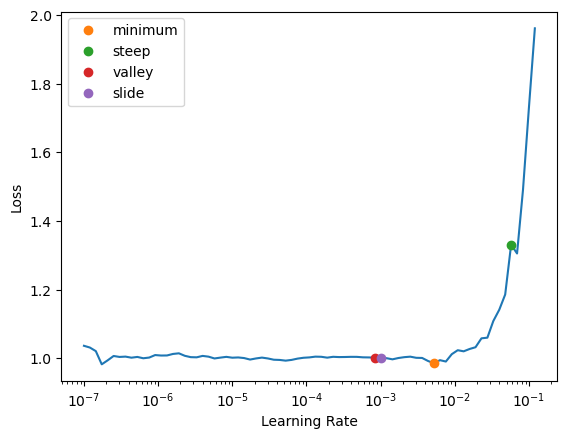

In [27]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [28]:
if random_seed:
    set_seed(random_seed)

learn.fit_one_cycle(4, slice(1e-5, 1e-3), cbs=fit_cbs)

epoch,train_loss,valid_loss,f1_score,time
0,0.509273,0.371147,0.849443,05:44
1,0.312491,0.306344,0.878328,05:47
2,0.377234,0.253131,0.897531,05:44
3,0.261739,0.252422,0.900274,05:51


In [29]:
r = learn.recorder
r.metric_names, r.values

((#5) ['epoch','train_loss','valid_loss','f1_score','time'],
 [(#3) [0.5092725157737732,0.3711467683315277,0.8494432790059706],
  (#3) [0.31249114871025085,0.30634400248527527,0.8783282233338713],
  (#3) [0.37723371386528015,0.253131240606308,0.8975310634177828],
  (#3) [0.26173877716064453,0.2524218261241913,0.9002743262869131]])

In [30]:
learn.export("topic_segmentation_learner.pkl")

## Inference

In [231]:
raw_train_df.course_title.unique().tolist()

['C-Squared Podcast',
 'Full Stack Deep Learning - Spring 2021',
 'ali - how to start a business',
 'cc - how to invest in stocks',
 'dr berg - adrenal body type',
 'dr berg - cereal vid',
 'dr berg - diabetes myth',
 'dr berg - how to fast',
 'dr berg - what happens when you fast',
 'fast.ai 2022 - Part 1',
 'markowskyart - begginer drawing course',
 'parker - learn photography']

In [466]:
# val_course_title = random.choice(train_df.iloc[val_idxs]["course_title"].unique().tolist())
# val_course_title

val_course_title = "Full Stack Deep Learning - Spring 2021"
val_lesson_num = "3"

In [467]:
inf_df = raw_train_df[
    (raw_train_df["course_title"] == val_course_title) & (raw_train_df["lesson_num"] == val_lesson_num)
].copy()
inf_df.reset_index(inplace=True)

print(len(inf_df))
inf_df.head()

627


,level_0,index,course_title,lesson_num,topic,seq,next_seq,is_topic_end,next_topic_begin_seq,other_topic_seqs
0,2613,2613,Full Stack Deep Learning - Spring 2021,3,Introduction,okay so so let's dive in and talk about recurrent neural networks um and so recurrent neural networks at a,high level um this is sort of like an analog in some sense for convolutional neural networks,False,NaN,"[uh for sequence data um and you know that idea of being similar right that we're going to try to exploit some structure, about the data that's coming into the model um in this case the fact that the data is coming in in the sequence to build a more efficient, neural net architecture um hang on a second, all right so what we're going to cover today um first we'll talk about sequence problems and just what are some of the types of, problems you can solve with these architectures then we'll talk about recurrent neural networks which are the main family of, architectures we'll be talking abou..."
1,2614,2614,Full Stack Deep Learning - Spring 2021,3,Introduction,high level um this is sort of like an analog in some sense for convolutional neural networks,uh for sequence data um and you know that idea of being similar right that we're going to try to exploit some structure,False,NaN,"[okay so so let's dive in and talk about recurrent neural networks um and so recurrent neural networks at a, about the data that's coming into the model um in this case the fact that the data is coming in in the sequence to build a more efficient, neural net architecture um hang on a second, all right so what we're going to cover today um first we'll talk about sequence problems and just what are some of the types of, problems you can solve with these architectures then we'll talk about recurrent neural networks which are the main family of, architectures we'll be talking about today and w..."
2,2615,2615,Full Stack Deep Learning - Spring 2021,3,Introduction,uh for sequence data um and you know that idea of being similar right that we're going to try to exploit some structure,about the data that's coming into the model um in this case the fact that the data is coming in in the sequence to build a more efficient,False,NaN,"[okay so so let's dive in and talk about recurrent neural networks um and so recurrent neural networks at a, high level um this is sort of like an analog in some sense for convolutional neural networks, neural net architecture um hang on a second, all right so what we're going to cover today um first we'll talk about sequence problems and just what are some of the types of, problems you can solve with these architectures then we'll talk about recurrent neural networks which are the main family of, architectures we'll be talking about today and we'll talk about some of the problems with rec..."
3,2616,2616,Full Stack Deep Learning - Spring 2021,3,Introduction,about the data that's coming into the model um in this case the fact that the data is coming in in the sequence to build a more efficient,neural net architecture um hang on a second,False,NaN,"[okay so so let's dive in and talk about recurrent neural networks um and so recurrent neural networks at a, high level um this is sort of like an analog in some sense for convolutional neural networks, uh for sequence data um and you know that idea of being similar right that we're going to try to exploit some structure, all right so what we're going to cover today um first we'll talk about sequence problems and just what are some of the types of, problems you can solve with these architectures then we'll talk about recurrent neural networks which are the main family of, architectures we'..."
4,2617,2617,Full Stack Deep Learning - Spring 2021,3,Introduction,neural net architecture um hang on a second,all right so what we're going to cover today um first we'll talk about sequence problems and just what are some of the types of,False,NaN,"[okay so so let's dive in and talk about recurrent neural networks um and so 

In [468]:
# inf_df.tail()

In [469]:
inf_df.drop(inf_df.index[-1], inplace=True)

In [518]:
inf_learner = load_learner("topic_segmentation_learner.pkl")
inf_dl = inf_learner.dls.test_dl(inf_df)

In [551]:
for idx, b in enumerate(inf_dl):
    print(hf_tokenizer.decode(b[0]["input_ids"][0]))
    print(hf_tokenizer.decode(b[1]["input_ids"][0]))
    print("---")
    print(hf_tokenizer.decode(b[0]["input_ids"][1]))
    print(hf_tokenizer.decode(b[1]["input_ids"][1]))
    print("---")
    print(hf_tokenizer.decode(b[0]["input_ids"][2]))
    print(hf_tokenizer.decode(b[1]["input_ids"][2]))
    print("---")
    print(len(b[0]["input_ids"]))

    scores = inf_learner.model.hf_model(b[0]["input_ids"], attention_mask=b[0]["attention_mask"])
    print(scores)
    print(torch.sigmoid(scores[0][:, 0]).detach().cpu().numpy().tolist())
    if idx == 0:
        break

[CLS] okay so so let's dive in and talk about recurrent neural networks um and so recurrent neural networks at a[SEP] high level um this is sort of like an analog in some sense for convolutional neural networks[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]
[CLS] okay so so let's dive in and talk about recurrent neural networks um and so recurrent neural networks at a[SEP] about the data that's coming into the model um in this case the fact that the data is coming in in the sequence to build a more efficient[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]
---
[CLS] high level um this is sort of like an analog in some sense for convolutional neural networks[SEP] uh for sequence data um and you know that idea of being similar right that we're going to try to exploit some structure[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]
[CLS] high level um this is sort of like an analog in some sense for convolution

In [ ]:
preds, _ = inf_learner.get_preds(dl=inf_dl)

In [471]:
print(len(preds), len(preds[0]), len(preds[1]))
print(preds[0][:5])
print(preds[1][:5])

2 626 626
tensor([4.0073, 3.5035, 1.9720, 3.1689, 1.2264])
tensor([-0.8434,  1.0984, -1.3691,  0.2587, -0.8578])


In [500]:
import statistics, segeval
from sklearn.metrics import mean_absolute_error, f1_score, recall_score, precision_score

In [473]:
scores = torch.sigmoid(preds[0]).detach().cpu().numpy().tolist()

print(len(scores))
print(scores[:10])

626
[0.9821426272392273, 0.9707868695259094, 0.8778219819068909, 0.9596469402313232, 0.7731872200965881, 0.9886969327926636, 0.9900349974632263, 0.9908639788627625, 0.98637855052948, 0.9772564172744751]


In [479]:
scores_np = np.array(scores)
print(scores_np.mean(), scores_np.std())

scores_np.mean() - (0.1 * scores_np.std())

0.8121584195036667 0.2311856467795268


0.789039854825714

In [480]:
def depth_score_cal(scores):
    output_scores = []
    for i in range(len(scores)):
        lflag = scores[i]
        rflag = scores[i]
        if i == 0:
            hl = scores[i]
            for r in range(i + 1, len(scores)):
                if rflag <= scores[r]:
                    rflag = scores[r]
                else:
                    break
        elif i == len(scores):
            hr = scores[i]
            for l in range(i - 1, -1, -1):
                if lflag <= scores[l]:
                    lflag = scores[l]
                else:
                    break
        else:
            for r in range(i + 1, len(scores)):
                if rflag <= scores[r]:
                    rflag = scores[r]
                else:
                    break
            for l in range(i - 1, -1, -1):
                if lflag <= scores[l]:
                    lflag = scores[l]
                else:
                    break
        depth_score = 0.5 * (lflag + rflag - 2 * scores[i])
        output_scores.append(depth_score)

    return output_scores

In [481]:
depth_scores = depth_score_cal(scores)

print(len(depth_scores))
print(depth_scores[:10])

626
[0.0, 0.0056778788566589355, 0.0930728018283844, 0.0, 0.2020682394504547, 0.0010835230350494385, 0.0004144906997680664, 0.0, 0.0022427141666412354, 0.006803780794143677]


In [482]:
depth_scores_np = np.array(depth_scores)
depth_scores_np.mean(), depth_scores_np.std(), depth_scores_np.var()

(0.09908506499168972, 0.1667738593307448, 0.02781352015607105)

In [516]:
threshold = sum(depth_scores) / (len(depth_scores)) - 0.1 * statistics.stdev(depth_scores)
print(threshold)

# TODO: A higher threshold seems better in every case; explore a different calculation than the above
# threshold = 0.755 # 0.755

0.08239434248236713


In [503]:
# c = 0
# pick_num = 3
# score_wd = 0
# score_mae = 0
# score_f1 = 0
# score_pk = 0
# dp_var = []

In [504]:
dp_var = [statistics.stdev(depth_scores)]

boundary_indice = []

seg_p_labels = [0] * (len(depth_scores))

# TODO: I'm pretty sure we should start with a 1
seg_p_labels[0] = 1

In [505]:
for i in range(len(depth_scores)):
    if depth_scores[i] > threshold:
        boundary_indice.append(i)

In [506]:
for i in boundary_indice:
    seg_p_labels[i] = 1

In [507]:
print(len(seg_p_labels))
print(seg_p_labels[:20])

626
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [508]:
tmp = 0
seg_p = []
for idx, fake in enumerate(seg_p_labels):
    if fake == 1 and idx != 0:
        # tmp += 1
        seg_p.append(tmp)
        tmp = 1
    else:
        tmp += 1
seg_p.append(tmp)

In [509]:
total = 0
for el in seg_p:
    total += el

print(len(seg_p))
print(seg_p)
print(total)

3
[327, 209, 90]
626


In [510]:
seg_r_labels = []
seg_r = []
tmp = 1

for r_idx, r in inf_df.iterrows():
    current_topic = r["topic"]
    if r_idx == 0:
        last_seen_topic = r["topic"]

    if last_seen_topic != current_topic:
        last_seen_topic = current_topic
        seg_r_labels.append(1)
        seg_r.append(tmp)
        tmp = 1
    else:
        seg_r_labels.append(0 if r_idx != 0 else 1)
        tmp += 1 if r_idx != 0 else 0

seg_r.append(tmp)

Calculate window_dff (WD) and PK

In [511]:
print(len(seg_r))
print(seg_r[:20])
print(seg_r[-20:])
print("")
print(len(seg_r_labels))
print(seg_r_labels[:20])
print(seg_r_labels[-20:])

9
[15, 48, 147, 55, 60, 119, 52, 26, 104]
[15, 48, 147, 55, 60, 119, 52, 26, 104]

626
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [512]:
print(len(seg_r), len(seg_p))

score_wd = segeval.window_diff(seg_p, seg_r)
print(score_wd)

score_pk = segeval.pk(seg_p, seg_r)
print(score_pk)

9 3
0.3604060913705583756345177665
0.3604060913705583756345177665


Calculate MAE and F1

In [513]:
print(len(seg_r_labels), len(seg_p_labels))
print(seg_r_labels[:20])
print(seg_p_labels[:20])
print("")
print(seg_r_labels[-20:])
print(seg_p_labels[-20:])

626 626
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [514]:
print(len(seg_r_labels), len(seg_p_labels))

score_mae = sum(list(map(abs, np.array(seg_r_labels) - np.array(seg_p_labels))))
print(score_mae)

print(f1_score(seg_r_labels, seg_p_labels, average="macro"))
print(precision_score(seg_r_labels, seg_p_labels, average="macro"))
print(recall_score(seg_r_labels, seg_p_labels, average="macro"))

626 626
10
0.5793010752688172
0.6602461209202782
0.5539348100126058


In [515]:
seg_idxs = [seg_idx for seg_idx, v in enumerate(seg_p_labels) if v == 1]
seg_idxs

[0, 327, 536]

In [498]:
inf_df.iloc[seg_idxs]

,level_0,index,course_title,lesson_num,topic,seq,next_seq,is_topic_end,next_topic_begin_seq,other_topic_seqs
0,2613,2613,Full Stack Deep Learning - Spring 2021,3,Introduction,okay so so let's dive in and talk about recurrent neural networks um and so recurrent neural networks at a,high level um this is sort of like an analog in some sense for convolutional neural networks,False,NaN,"[uh for sequence data um and you know that idea of being similar right that we're going to try to exploit some structure, about the data that's coming into the model um in this case the fact that the data is coming in in the sequence to build a more efficient, neural net architecture um hang on a second, all right so what we're going to cover today um first we'll talk about sequence problems and just what are some of the types of, problems you can solve with these architectures then we'll talk about recurrent neural networks which are the main family of, architectures we'll be talking abou..."
327,2940,2940,Full Stack Deep Learning - Spring 2021,3,Bidirectionality and Attention from Google's Neural Machine Translation,from back in 2016. so at one point this was running in production at google um i highly doubt that it is anymore um,but it's it's worth knowing about anyway [Music] so um one one thing i want to talk about,False,NaN,"[about machine translation and we're gonna introduce two ideas um one is by bi-directionality, and the other is attention so these are sort of the big ideas to take away from this section and um this is all from this one paper, is just in general if you're like reading machine learning application papers, what what are the questions that you might want to ask yourself to understand what's going on these papers um so here here are some questions i, think are worth asking one is just like first of all what is the problem that they're trying to solve so what are they using the neural, network..."
